In [226]:
import warnings
import re
import math
import string
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, make_scorer, classification_report, confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, HistGradientBoostingClassifier, BaggingClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeRegressor
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from catboost import CatBoostClassifier

from wordcloud import WordCloud
from nltk.corpus import twitter_samples
from nltk.corpus import words
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, BatchNormalization, SpatialDropout1D, Dropout, Bidirectional, GlobalAveragePooling1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
nltk.download('twitter_samples')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')
stop = stopwords.words('english')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /Users/ritayanpatra/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ritayanpatra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ritayanpatra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/ritayanpatra/nltk_data...
[nltk_data]   Package words is already up-to-date!


## Data Loading

In [6]:
data_df = pd.read_json('./data/Sarcasm_Headlines_Dataset.json', lines=True)

print(data_df.shape)
data_df.head()

(26709, 3)


,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [7]:
data_df.isnull().sum()

article_link    0
headline        0
is_sarcastic    0
dtype: int64

In [8]:
X = data_df['headline']
y = data_df['is_sarcastic'] 
print(X.shape, y.shape)

(26709,) (26709,)


## Data Split

Class Distribution: 
 is_sarcastic
0    14985
1    11724
Name: count, dtype: int64


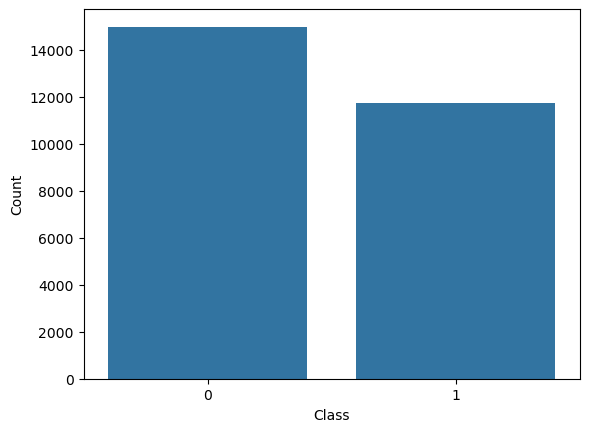

In [9]:
cd = y.value_counts()
print("Class Distribution: \n", cd)

sns.barplot(x=cd.index, y=cd.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [10]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, stratify=y_temp, test_size=0.2, random_state=42)
print(f"Train: {X_train.shape} {X_test.shape} | Test: {X_val.shape} {y_val.shape} | Test: {X_test.shape} {y_test.shape}")

Train: (17093,) (5342,) | Test: (4274,) (4274,) | Test: (5342,) (5342,)


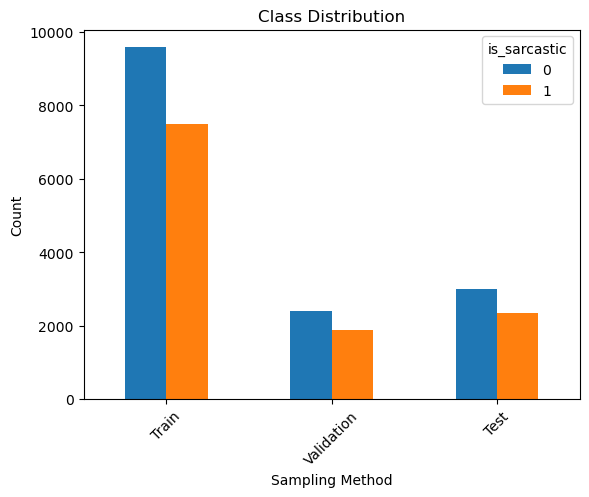

In [11]:
cd_train = y_train.value_counts()
cd_val = y_val.value_counts()
cd_test = y_test.value_counts()

cd_df = pd.DataFrame({
    'Train': cd_train,
    'Validation': cd_val,
    'Test': cd_test,
})

cd_df.T.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Sampling Method')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## Preprocessing

In [12]:
def text_cleaning(text):
    text = re.sub(r"[^A-Za-z0-9']", " ", text) # keep single quote for sarcasm
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r'\b\d+(?:\.\d+)?\s+', '', text)
    text = text.lower()
    return text

In [13]:
X_train = X_train.reset_index(drop = True)
count = 0
for i in range(len(X_train)):
    original_text = X_train[i]
    cleaned_text = text_cleaning(original_text)
    
    if original_text != cleaned_text:
        print("Original: ", original_text)
        print("Cleaned: ", cleaned_text)
        print("-" * 50)
        count +=1
    if count>=10: break

Original:  instagram influencers are all starting to look the same. here's why.
Cleaned:  instagram influencers are all starting to look the same  here  why 
--------------------------------------------------
Original:  researchers say that first warning sign of alcoholism generally driving over curb, plowing through fire hydrant, and crashing into aquarium
Cleaned:  researchers say that first warning sign of alcoholism generally driving over curb  plowing through fire hydrant  and crashing into aquarium
--------------------------------------------------
Original:  5 essential lists to make before the end of this year
Cleaned:  essential lists to make before the end of this year
--------------------------------------------------
Original:  controversial study links e-cigarettes to formaldehyde exposure
Cleaned:  controversial study links e cigarettes to formaldehyde exposure
--------------------------------------------------
Original:  here's christine baranski watching trump's inaugur

In [14]:
X_test = X_test.reset_index(drop = True)
for i in range(len(X_test)):
    original_text = X_test[i]
    cleaned_text = text_cleaning(original_text)

X_val = X_val.reset_index(drop = True)
for i in range(len(X_val)):
    original_text = X_val[i]
    cleaned_text = text_cleaning(original_text)

In [15]:
stopwords = set(stopwords.words('english'))
def remove_stopwords(sentence):
    words = sentence.split()
    clean_words = [word for word in words if word.lower() not in stopwords]
    return ' '.join(clean_words)
x_train_clean = X_train.apply(remove_stopwords)
x_val_clean = X_val.apply(remove_stopwords)
x_test_clean = X_test.apply(remove_stopwords)
print(x_train_clean.head(10))

0    instagram influencers starting look same. here...
1    researchers say first warning sign alcoholism ...
2                           failing way success brazil
3      nation kept night sound creaking infrastructure
4                      5 essential lists make end year
5    materialistic single mom constantly thinking m...
6                     man forgets infant strapped back
7    controversial study links e-cigarettes formald...
8    here's christine baranski watching trump's ina...
9                        ovarian cancer gets publicist
Name: headline, dtype: object


In [16]:
def remove_punctuations(sentence):
    return sentence.translate(str.maketrans('', '', string.punctuation))
x_train_clean = x_train_clean.apply(remove_punctuations)
x_val_clean = x_val_clean.apply(remove_punctuations)
x_test_clean = x_test_clean.apply(remove_punctuations)
print(x_train_clean.head(10))

0    instagram influencers starting look same heres...
1    researchers say first warning sign alcoholism ...
2                           failing way success brazil
3      nation kept night sound creaking infrastructure
4                      5 essential lists make end year
5    materialistic single mom constantly thinking m...
6                     man forgets infant strapped back
7    controversial study links ecigarettes formalde...
8    heres christine baranski watching trumps inaug...
9                        ovarian cancer gets publicist
Name: headline, dtype: object


## Feature Extraction

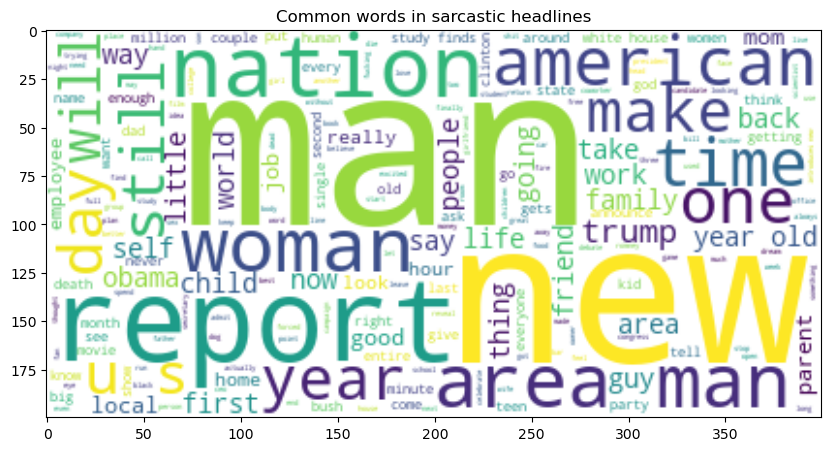

In [17]:
wc = WordCloud(background_color='white').generate(' '.join(data_df[data_df['is_sarcastic'] == 1].headline))

plt.figure(figsize=(10, 12))
plt.imshow(wc, interpolation='bilinear')
plt.title("Common words in sarcastic headlines")
plt.show()

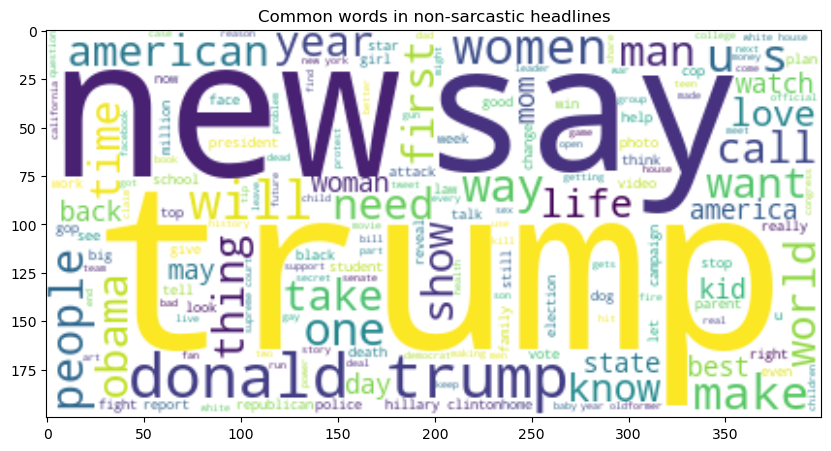

In [18]:
wc = WordCloud(background_color='white').generate(' '.join(data_df[data_df['is_sarcastic'] == 0].headline))

plt.figure(figsize=(10, 12))
plt.imshow(wc, interpolation='bilinear')
plt.title("Common words in non-sarcastic headlines")
plt.show()

## Bag of Words

In [19]:
vector = CountVectorizer()
x_train_vectors = vector.fit_transform(x_train_clean)
x_val_vectors = vector.transform(x_val_clean)
x_test_vectors = vector.transform(x_test_clean)
x_train_vectors

<17093x22743 sparse matrix of type '<class 'numpy.int64'>'
	with 120641 stored elements in Compressed Sparse Row format>

In [20]:
model_bow = LogisticRegression()
model_bow.fit(x_train_vectors, y_train)

LogisticRegression()

In [21]:
y_pred_bow = model_bow.predict(x_test_vectors)
y_pred_bow

array([0, 0, 1, ..., 0, 1, 0])

Accuracy: 0.7884687383002621

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.85      0.82      2997
           1       0.79      0.70      0.74      2345

    accuracy                           0.79      5342
   macro avg       0.79      0.78      0.78      5342
weighted avg       0.79      0.79      0.79      5342



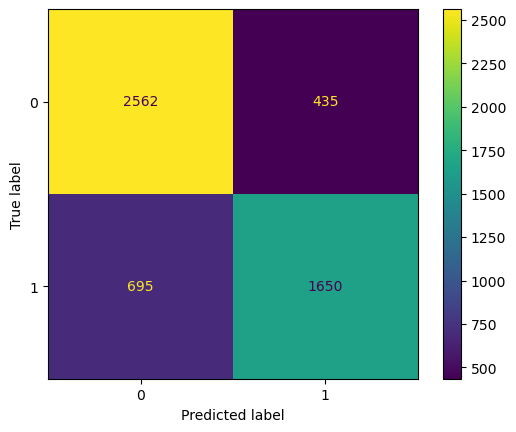

In [22]:
accuracy_bow = accuracy_score(y_test, y_pred_bow)
print(f"Accuracy: {accuracy_bow}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_bow))
disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred_bow))
disp.plot()

## TF-IDF

In [23]:
vector = TfidfVectorizer(max_features = 5000)
x_train_vectors = vector.fit_transform(x_train_clean)
x_val_vectors = vector.transform(x_val_clean)
x_test_vectors = vector.transform(x_test_clean)

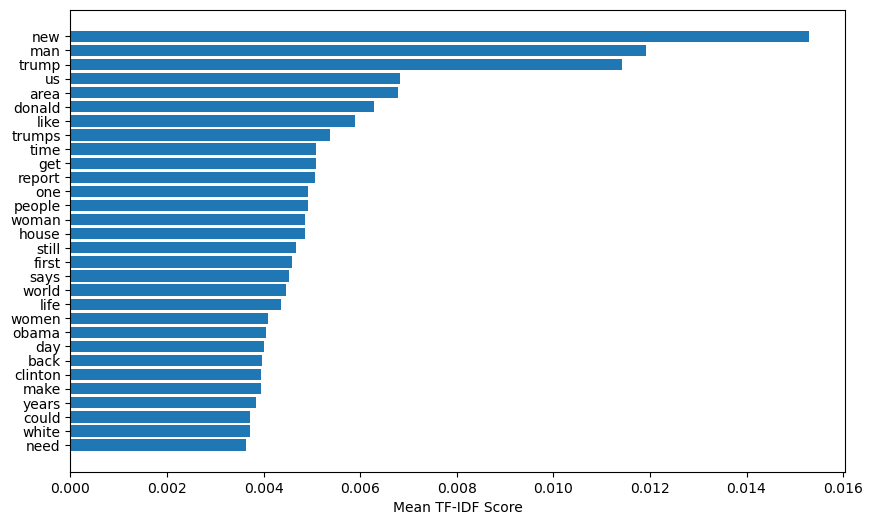

In [24]:
score_df = pd.DataFrame({"word": vector.get_feature_names_out(), "mean_tfidf": x_test_vectors.mean(axis = 0).A1})
top_words = score_df.nlargest(30, "mean_tfidf")

plt.figure(figsize=(10, 6))
plt.barh(top_words["word"], top_words["mean_tfidf"], align="center")
plt.gca().invert_yaxis()
plt.xlabel("Mean TF-IDF Score")
plt.show()

## Regressor/Tree-Based Models (TF-IDF)

In [25]:
tree_models = {
    "Logistic Regressor": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(),
    "LightGBM": LGBMClassifier(verbose=0),
    "Extra Trees": ExtraTreesClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Bagging": BaggingClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0)
}

param_grids = {
    "Logistic Regressor":{
        "penalty": ["l1", "l2"],
        "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        "solver": ["liblinear", "saga"],
        "max_iter": [5000]
    },
    "Decision Tree": {
        "criterion": ["gini", "entropy"],
        "max_depth": [10, 20, 30, 50, None],
        "min_samples_split": [2, 5, 10, 25],
        "min_samples_leaf": [1, 2, 5, 10]
    },
    "Random Forest": {
        "n_estimators": [50, 100, 200, 500],
        "max_depth": [10, 20, 40, None],
        "min_samples_split": [2, 5, 10],
        "max_features": ["sqrt", "log2", None]
    },
    "Gradient Boosting": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.001, 0.005, 0.01, 0.05, 0.1, 1.0],
        "max_depth": [3, 5, 7],
        "subsample": [0.7, 0.8, 1.0]
    },
    "XGBoost": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.001, 0.005, 0.01, 0.05, 0.1, 1.0],
        "max_depth": [3, 5, 7],
        "eval_metric": ["logloss"],
        "colsample_bytree": [0.7, 0.8, 1.0],
        "gamma": [0, 0.1, 0.3, 0.5]
    },
    "LightGBM": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "num_leaves": [20, 31, 40],
        "max_bin": [63, 127, 255],
        "min_child_samples": [10, 20, 30, 50],
        "boosting_type": ["gbdt", "dart"]
    },
    "Extra Trees": {
        "n_estimators": [50, 100, 200],
        "max_depth": [10, 20, None],
        "min_samples_split": [2, 5, 10],
        "max_features": ["sqrt", "log2", None],
        "min_samples_leaf": [1, 2, 5],
        "bootstrap": [True, False]
    },
    "AdaBoost": {
        "n_estimators": [10, 50, 100, 200, 500],
        "learning_rate": [0.001, 0.005, 0.01, 0.05, 0.1, 1.0],
        "algorithm": ["SAMME"],
    },              
    "Bagging": {
        "n_estimators": [10, 25, 50, 100],
        "max_samples": [0.5, 0.7, 0.9, 1.0],
        "max_features": [0.2, 0.5, 0.8, 1.0],
        "bootstrap": [True, False]
    },
    "CatBoost":{
        "iterations": [100, 200, 300],
        "learning_rate": [0.01, 0.1, 0.2],
        "depth": [3, 5, 7],
        "l2_leaf_reg": [1, 3, 5, 10],
        "bagging_temperature": [0, 0.5, 1.0],
        "grow_policy": ["SymmetricTree", "Depthwise", "Lossguide"]
    },
}

In [26]:
tree_results = {}
for model_name, model in tree_models.items():
    print(f"Training {model_name}...")
    
    search = RandomizedSearchCV(
        model,
        param_distributions=param_grids[model_name],
        n_iter=20,
        scoring={
            'f1': make_scorer(f1_score, average='weighted'),
            'accuracy': make_scorer(accuracy_score)
        },
        refit='f1',  
        cv=3,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )
    search.fit(x_train_vectors, y_train)
    tree_results[model_name] = {"cv_results": pd.DataFrame(search.cv_results_), "best_estimator": search.best_estimator_}

Training Logistic Regressor...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Training Decision Tree...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Training Random Forest...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Training Gradient Boosting...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Training XGBoost...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Training LightGBM...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Training Extra Trees...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Training AdaBoost...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Training Bagging...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Training CatBoost...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


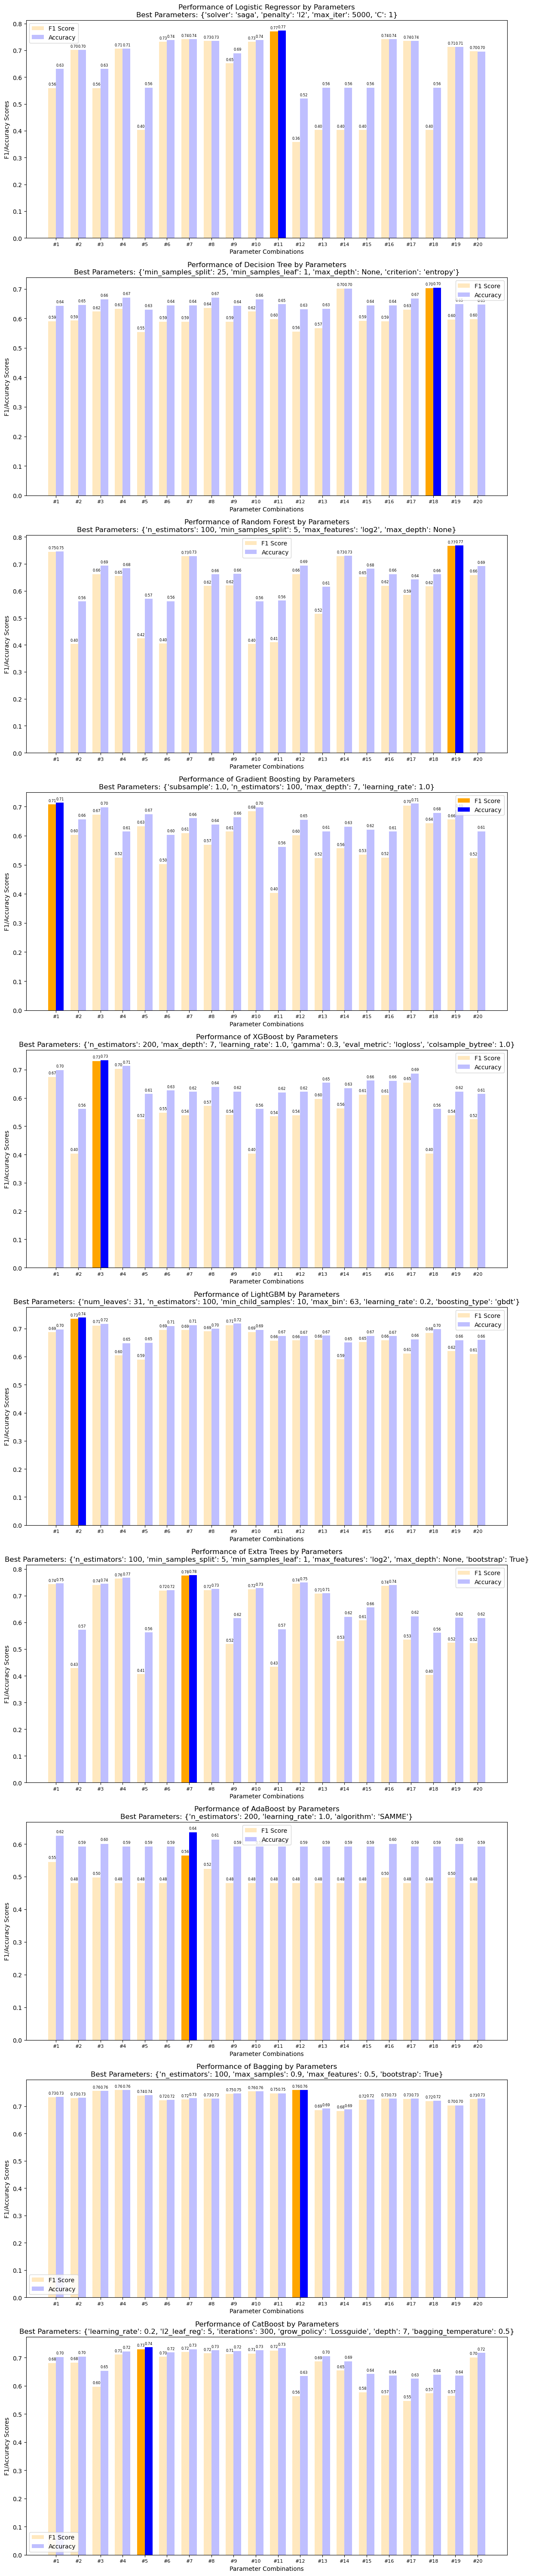

In [27]:
fig, axes = plt.subplots(len(tree_results), 1, figsize=(12, 6 * len(tree_results)))

for ax, (model_name, model_data) in zip(axes, tree_results.items()):
    # Best parameter combination
    best_index = model_data["cv_results"]["rank_test_f1"].idxmin()
  
    # F1 and Accuracy Scores
    f1_scores = model_data["cv_results"]["mean_test_f1"]
    accuracy_scores = model_data["cv_results"]["mean_test_accuracy"]

    for i, f1 in enumerate(f1_scores):
        ax.bar(
            i - 0.35 / 2,
            f1,
            width=0.35,
            color='orange' if i == best_index else 'orange',
            alpha=1.0 if i == best_index else 0.25,
            label='F1 Score' if i == 0 else None
        )
    for i, acc in enumerate(accuracy_scores):
        ax.bar(
            i + 0.35 / 2,
            acc,
            width=0.35,
            color='blue' if i == best_index else 'blue',
            alpha=1.0 if i == best_index else 0.25,
            label='Accuracy' if i == 0 else None
        )

    for i, (f1, acc) in enumerate(zip(f1_scores, accuracy_scores)):
        ax.text(i - 0.35 / 2, f1 + 0.01, f"{f1:.2f}", ha="center", fontsize=6)
        ax.text(i + 0.35 / 2, acc + 0.01, f"{acc:.2f}", ha="center", fontsize=6)

    ax.set_title(f"Performance of {model_name} by Parameters\nBest Parameters: {model_data["cv_results"].loc[best_index, "params"]}")
    ax.set_xlabel("Parameter Combinations")
    ax.set_ylabel("F1/Accuracy Scores")
    ax.set_xticks(range(len(model_data["cv_results"])))
    ax.set_xticklabels([f"#{i+1}" for i in range(len(model_data["cv_results"]))], rotation=0, ha="center", fontsize=8)
    ax.legend()

plt.tight_layout()
plt.show()

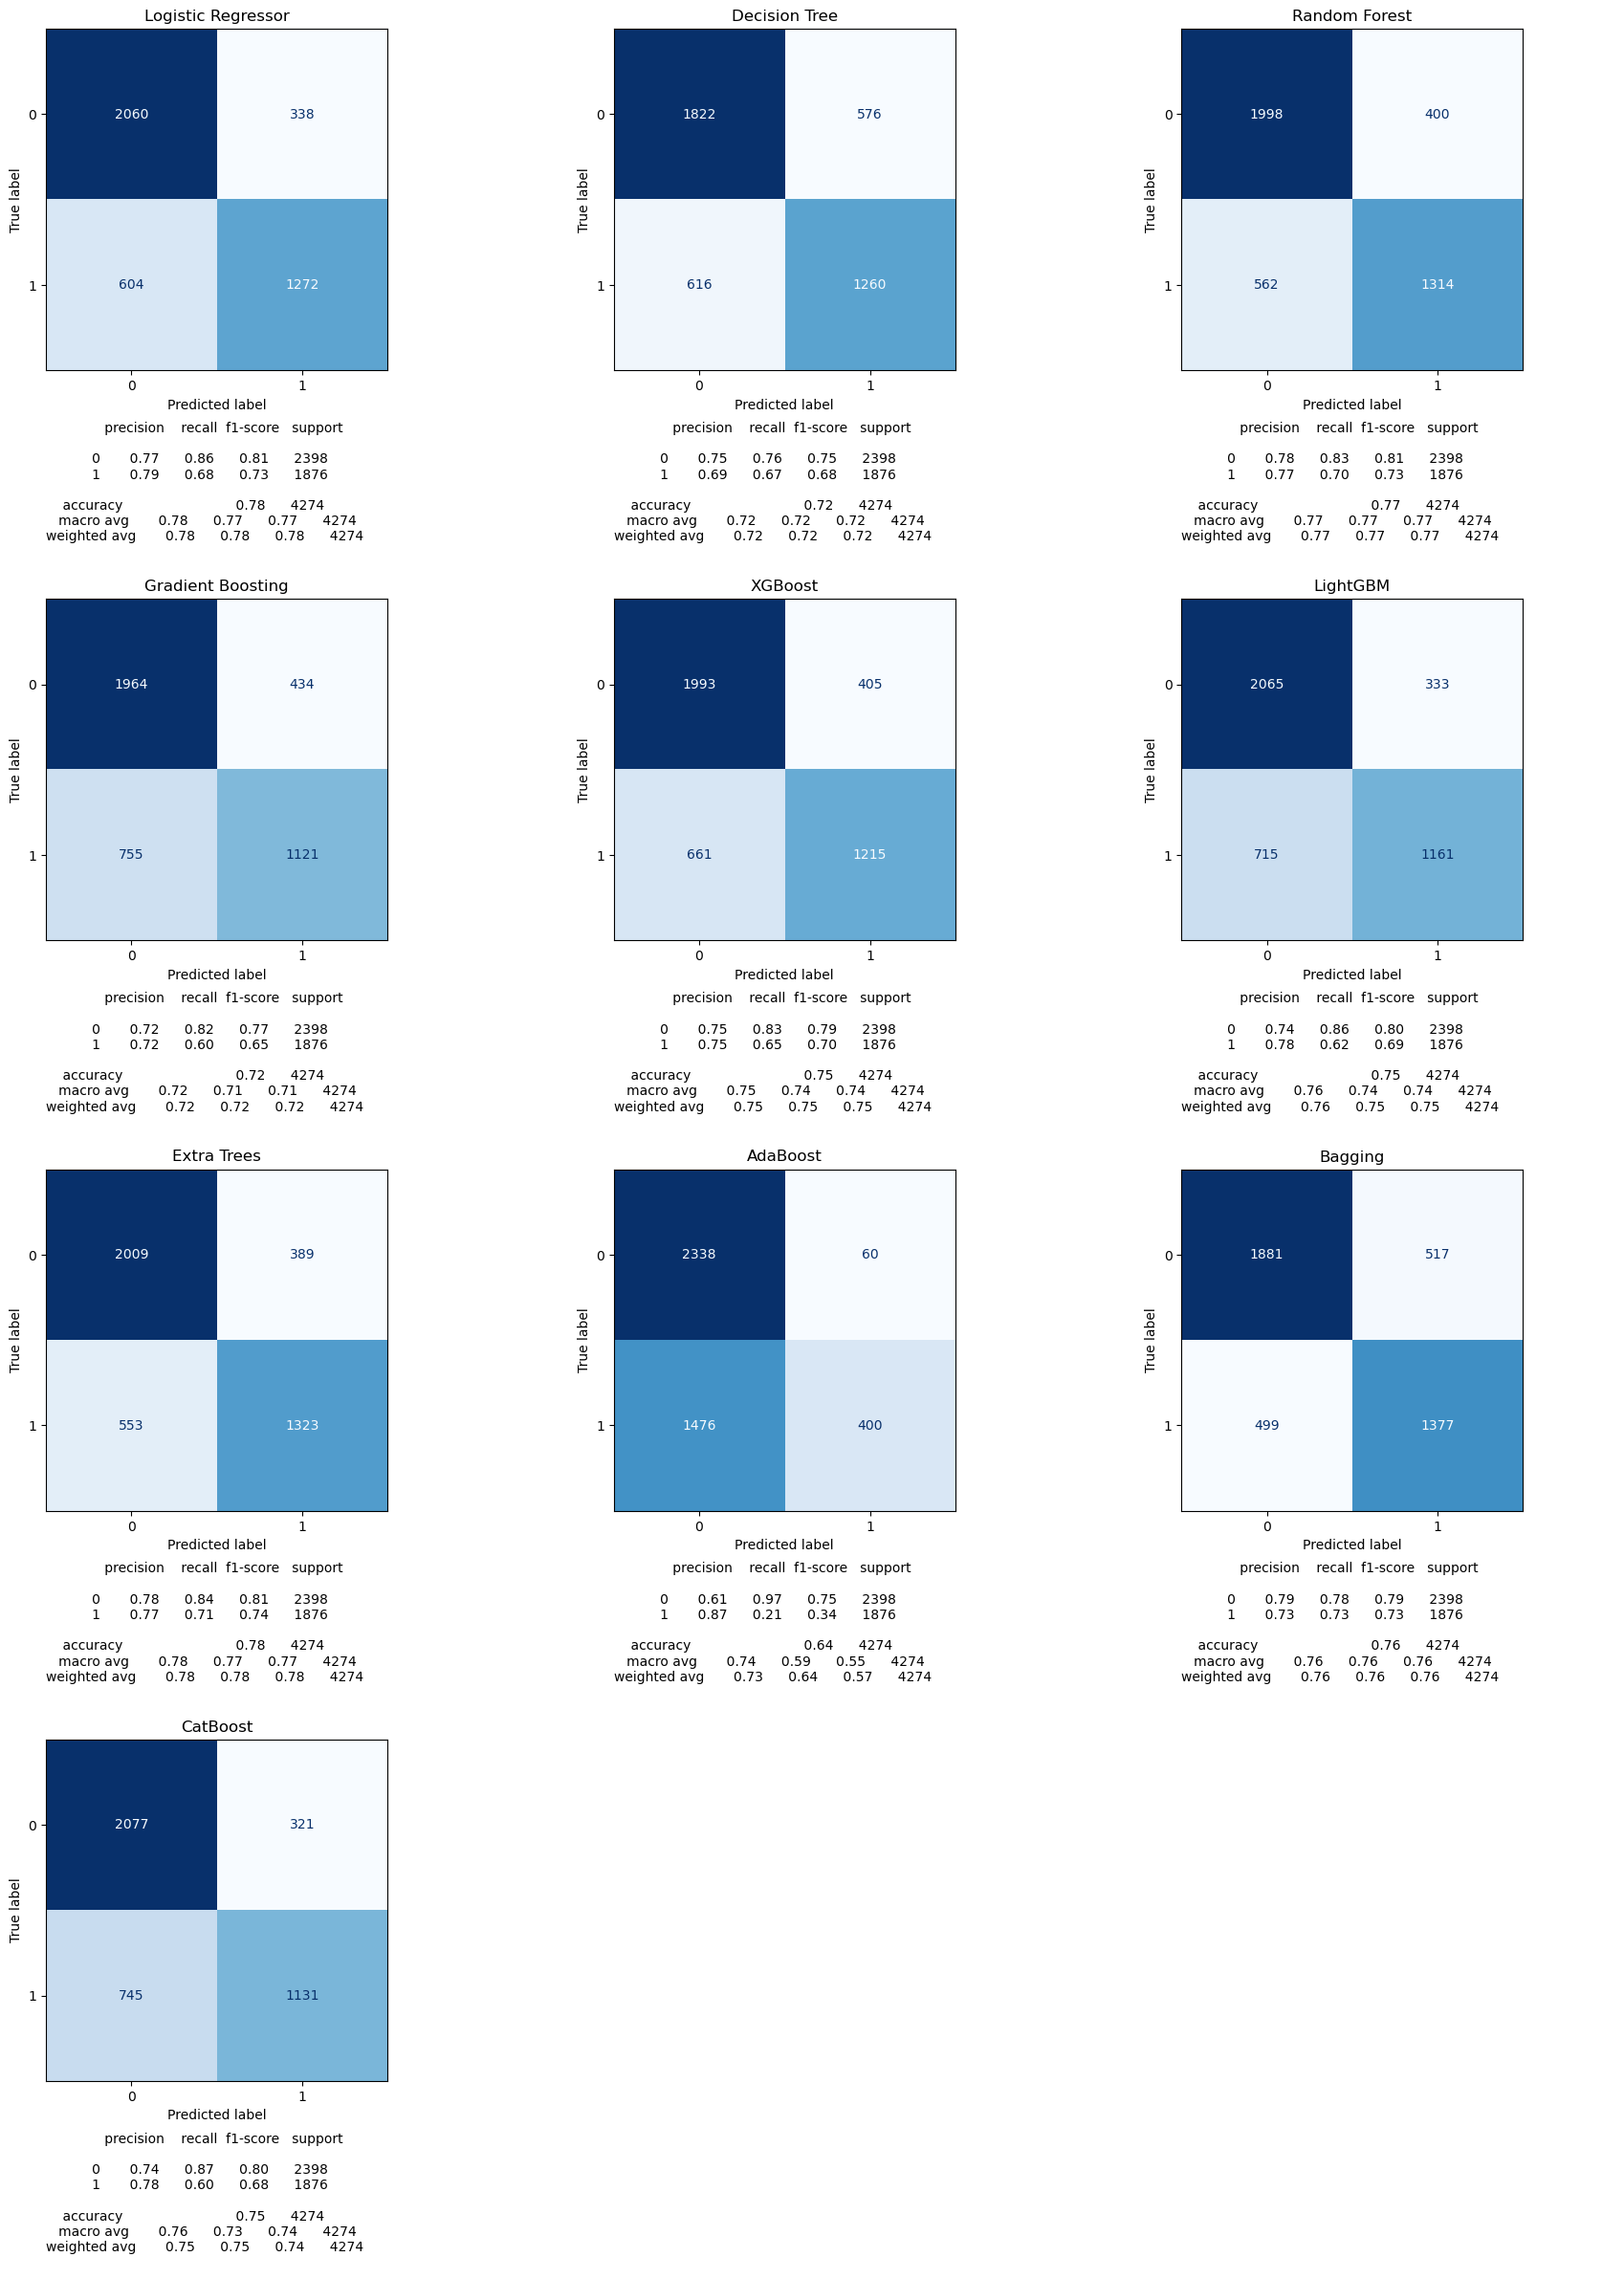

In [28]:
n_rows = math.ceil(len(tree_results) / 3)
fig, axes = plt.subplots(n_rows, 3, figsize=(18, 6 * n_rows))

for ax, (model_name, model_data) in zip(axes.flatten(), tree_results.items()):
    best_model = model_data["best_estimator"]
    y_val_pred = best_model.predict(x_val_vectors)

    # Confusion_matrix
    cm = confusion_matrix(y_val, y_val_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(f"{model_name}")

    # Classification report
    report = classification_report(y_val, y_val_pred)
    ax.text(0.0, -0.15, report, transform=ax.transAxes, fontsize=10, va='top', wrap=True)

# Unused subplots
for ax in axes.flatten()[len(tree_results):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

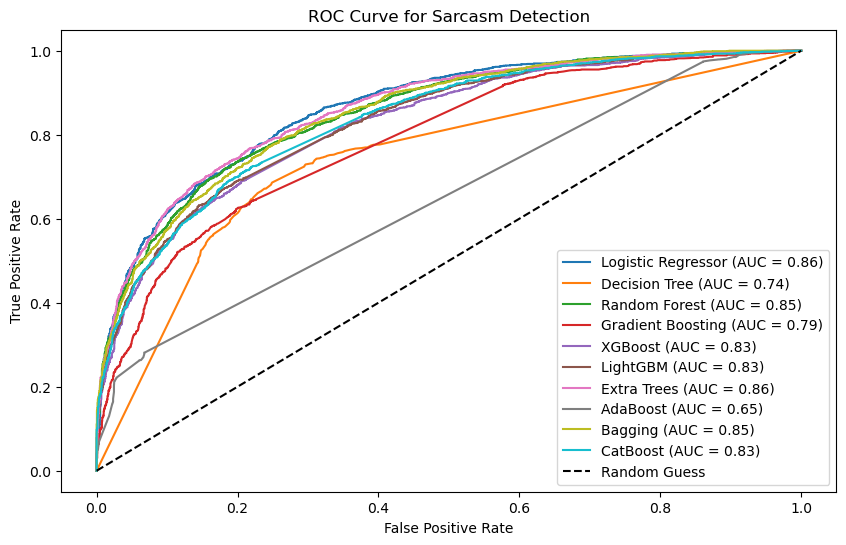

In [29]:
fig, ax = plt.subplots(figsize=(10, 6))

for model_name, model_data in tree_results.items():
    best_model = model_data["best_estimator"]

    # Probabilities for is_sarcastic=1
    y_val_proba = best_model.predict_proba(x_val_vectors)[:, 1]

    # ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_val, y_val_proba)
    auc_score = roc_auc_score(y_val, y_val_proba)

    ax.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.2f})")

ax.plot([0, 1], [0, 1], "k--", label="Random Guess") # For reference
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve for Sarcasm Detection")
ax.legend(loc="lower right")
plt.show()

### Long Short Term Memory (LSTM) Deep Learning Model

The information source: @https://medium.com/@neri.vvo/how-to-use-lstm-in-nlp-tasks-text-classification-example-3222db759337#:~:text=In%20NLP%2C%20LSTMs%20are%20typically,previous%20inputs%20in%20%E2%80%9Cmemory.%E2%80%9D

Natural language processing (NLP) tasks frequently employ the Recurrent Neural Network (RNN) variant known as Long Short-Term Memory (LSTM). RNNs are neural networks that process sequential data, such as time series data or text written in a natural language.

### Central Role of an LSTM Model

- **Cell State**: 
  - The key component of an LSTM model is the **cell state**, which maintains its state over time.
  - The **cell state** can be visualized as a horizontal line running through the top of the diagram.
  - The cell state functions like a conveyor belt through which information flows, mostly unchanged.
  - Information can be added or removed from the cell state through gates, which control the flow of information in and out.

- **Gates in LSTM**:
  - LSTMs have a set of gates that regulate the flow of information:
    - **Input Gate**: Controls the flow of new information into the cell.
    - **Forget Gate**: Regulates the flow of information out of the cell.
    - **Output Gate**: Manages the data flow into the LSTM’s output.

- **Mechanism of Operation**:
  - LSTMs use a system of **memory cells** that store information and transmit it across time steps.
  - These cells are interconnected by gates, which ensure that only the relevant information is retained and passed along.
  - The gates employ pointwise multiplication and a **sigmoid neural net layer** to manage the information flow.

### Summary of Gate Functions
- **Input Gate**: Adds new information to the cell state.
- **Forget Gate**: Removes unnecessary information from the cell state.
- **Output Gate**: Sends relevant information to the output.
  
By controlling the flow of information in this way, LSTMs can **forget irrelevant information** while **retaining important data** over longer sequences.

### Preprocessing 

The `apply_lemmatize` function uses the `WordNetLemmatizer` from NLTK to convert each word in a given text to its base verb form. It splits the text into words, lemmatizes each as a verb, and then joins them back into a single string. For example, “running jumped swimming” becomes “run jump swim”.

In [227]:
lemmatizer = WordNetLemmatizer()
def apply_lemmatize(text):
    words = text.split()
    res = []
    for word in words:
        word = lemmatizer.lemmatize(word, pos='v')
        res.append(word)
    
    return ' '.join(res)


In [228]:
x_train_lemma = x_train_clean.apply(apply_lemmatize)
x_val_lemma = x_val_clean.apply(apply_lemmatize)
x_test_lemma = x_test_clean.apply(apply_lemmatize)

The provided code snippet initializes a `Tokenizer` from the Keras library for text preprocessing in natural language processing tasks. Here’s a brief explanation of each component:
- `max_features = 500000`: Sets the maximum number of words to keep based on word frequency. Only the top 500,000 most common words will be retained in the tokenizer’s vocabulary.
- `max_length = 30`: Typically defines the maximum length of sequences after tokenization, often used later with padding or truncation.

`Tokenizer` Initialization:
- `num_words=max_features`: Limits the tokenizer to the most frequent 500,000 words.
- `split=' '`: Specifies that words in the input text should be split by spaces.
- `filters=string.punctuation`: Removes all punctuation from the text before tokenization.
- `lower=True`: Converts all text to lowercase before tokenization, ensuring uniformity in word representation.
This setup is commonly used in preparing text data for training machine learning models, particularly in tasks like text classification or sentiment analysis.

In [242]:
max_features = 500000  # Maximum number of words to keep
max_length = 30

tokenizer = Tokenizer(
    num_words=max_features,    
    split=' ',                 
    filters=string.punctuation,  
    lower=True                
)

In [243]:
tokenizer.fit_on_texts(x_train_clean.values)

In [244]:
x_train_token = tokenizer.texts_to_sequences(x_train_clean)
x_train_token = pad_sequences(x_train_token, maxlen=max_length, padding='post', truncating='post')
x_test_token = tokenizer.texts_to_sequences(x_test_clean)
x_test_token = pad_sequences(x_test_token, maxlen=max_length, padding='post', truncating='post')
x_val_token = tokenizer.texts_to_sequences(x_val_clean)
x_val_token = pad_sequences(x_val_token, maxlen=max_length, padding='post', truncating='post')

In [245]:
x_train_token

array([[ 1459, 11203,   628, ...,     0,     0,     0],
       [ 1316,    51,    12, ...,     0,     0,     0],
       [ 2142,    35,   712, ...,     0,     0,     0],
       ...,
       [22800, 22801,  1135, ...,     0,     0,     0],
       [  111,   157,  2230, ...,     0,     0,     0],
       [  459, 22802,  1189, ...,     0,     0,     0]], dtype=int32)

In [246]:
print('Found %s unique tokens.' % len(tokenizer.word_index))
print('Sequence shape:', x_train_token.shape)

Found 22802 unique tokens.
Sequence shape: (17093, 30)


In [247]:
model = Sequential()
model.add(Embedding(
                input_dim=len(tokenizer.word_index) + 1, 
                output_dim=30,
                input_length=max_length,
                trainable=True
            )
         )
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(100, 
               return_sequences=False,
              )
         ))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(
                64, 
                activation='relu', 
                kernel_regularizer=l2(0.001)
            )
         )
model.add(Dropout(0.4))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['acc'])
model.build(input_shape=(None, max_length))
model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)        │ (None, 30, 30)         │       684,090 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_19            │ (None, 30, 30)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 200)            │       104,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 802,619 (3.06 MB)

 Trainable params: 802,219 (3.06 MB)

 Non-trainable params: 400 (1.56 KB)

The provided code defines and compiles a neural network model using the Keras library, specifically for a binary classification task. Here’s a breakdown of each component in the model:

**Model Architecture**<br>

1. Sequential Model:<br>
   The model is created using Keras’ `Sequential` API, which allows for building a linear stack of layers.

2. Embedding Layer:<br>
   `input_dim=len(tokenizer.word_index) + 1`: Sets the size of the vocabulary. It is based on the tokenizer’s word index size plus one for padding or unknown tokens.<br>
    `output_dim=30`: The dimension of the dense embedding vectors.<br>
	`input_length=max_length`: The length of input sequences, set to 30.<br>
	`trainable=True`: Allows the embedding weights to be updated during training.<br>
3. SpatialDropout1D Layer:<br>
   Applies dropout to the 1D input to prevent overfitting, with a dropout rate of 0.3.<br>
4. Bidirectional LSTM Layer:<br>
   `LSTM(100)`: An LSTM layer with 100 units.<br>
   `return_sequences=False`: Outputs only the last output in the output sequence.<br>
   Wrapped in `Bidirectional`, which processes input from both directions to capture dependencies in sequences more effectively.<br>
5. BatchNormalization Layer:<br>
   Normalizes the inputs of the layer to improve convergence and stability during training.<br>
6. Dropout Layer:<br>
   Adds dropout with a rate of 0.3 to reduce overfitting by randomly setting input units to zero during training.<br>
7. Dense Layer:<br>
   `units=64`: A fully connected layer with 64 neurons.<br>
   `activation='relu'`: Uses ReLU activation function.<br>
   `kernel_regularizer=l2(0.001)`: Applies L2 regularization to reduce overfitting.<br>
8. Another Dropout Layer:<br>
   Adds dropout with a rate of 0.4 for further regularization.<br>
9. Output Dense Layer:<br>
   `units=1`, `activation='sigmoid'`: A single neuron output layer with sigmoid activation for binary classification.<br>

**Compilation**<br>
- Optimizer: `adam`, which is an adaptive learning rate optimization algorithm.
- Loss Function: `binary_crossentropy`, suitable for binary classification tasks.
- Metrics: `acc`, which tracks accuracy during training and evaluation.

**Model Summary**<br>
- The `model.summary()` call provides a summary of the model architecture, including each layer’s type, output shape, and number of parameters.

This model is designed for text-based binary classification tasks, such as sentiment analysis, where it learns to classify sequences into one of two categories.

In [248]:
early_stopping = EarlyStopping(
    monitor='val_loss',      
    patience=10,             
    restore_best_weights=True  
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',      
    factor=0.2,              
    patience=5,              
    min_lr=0.00001           
)
checkpoint = ModelCheckpoint(
    filepath='best_model.keras', 
    monitor='val_loss', 
    save_best_only=True
)


The code snippet sets up three Keras callbacks to enhance the training process of a neural network model: `EarlyStopping`, `ReduceLROnPlateau`, and `ModelCheckpoint`. Below is a brief explanation of each:

1. EarlyStopping
- **Purpose**: Stops training when the monitored metric, `val_loss` (validation loss), stops improving.
- **Parameters**:
  - `monitor='val_loss'`: Monitors the validation loss.
  - `patience=10`: Waits for 10 epochs without improvement before stopping.
  - `restore_best_weights=True`: Restores the model weights from the epoch with the best validation loss, ensuring the best model is used.

2. ReduceLROnPlateau
- **Purpose**: Reduces the learning rate when a metric has stopped improving, allowing finer adjustments to weights.
- **Parameters**:
  - `monitor='val_loss'`: Monitors the validation loss.
  - `factor=0.2`: Reduces the learning rate by multiplying it by 0.2.
  - `patience=5`: Waits for 5 epochs without improvement before reducing the learning rate.
  - `min_lr=0.00001`: Sets a lower bound on the learning rate.

3. ModelCheckpoint
- **Purpose**: Saves the model or weights at specified intervals, particularly when performance improves.
- **Parameters**:
  - `filepath='best_model.keras'`: Path where the model is saved.
  - `monitor='val_loss'`: Monitors the validation loss to determine when to save.
  - `save_best_only=True`: Saves only when there is an improvement in validation loss, ensuring that only the best-performing model is retained.<br>

**Summary**
- These callbacks help optimize training by:
    - Preventing overfitting.
    - Dynamically adjusting learning rates.
    - Ensuring that the best model configuration is saved.

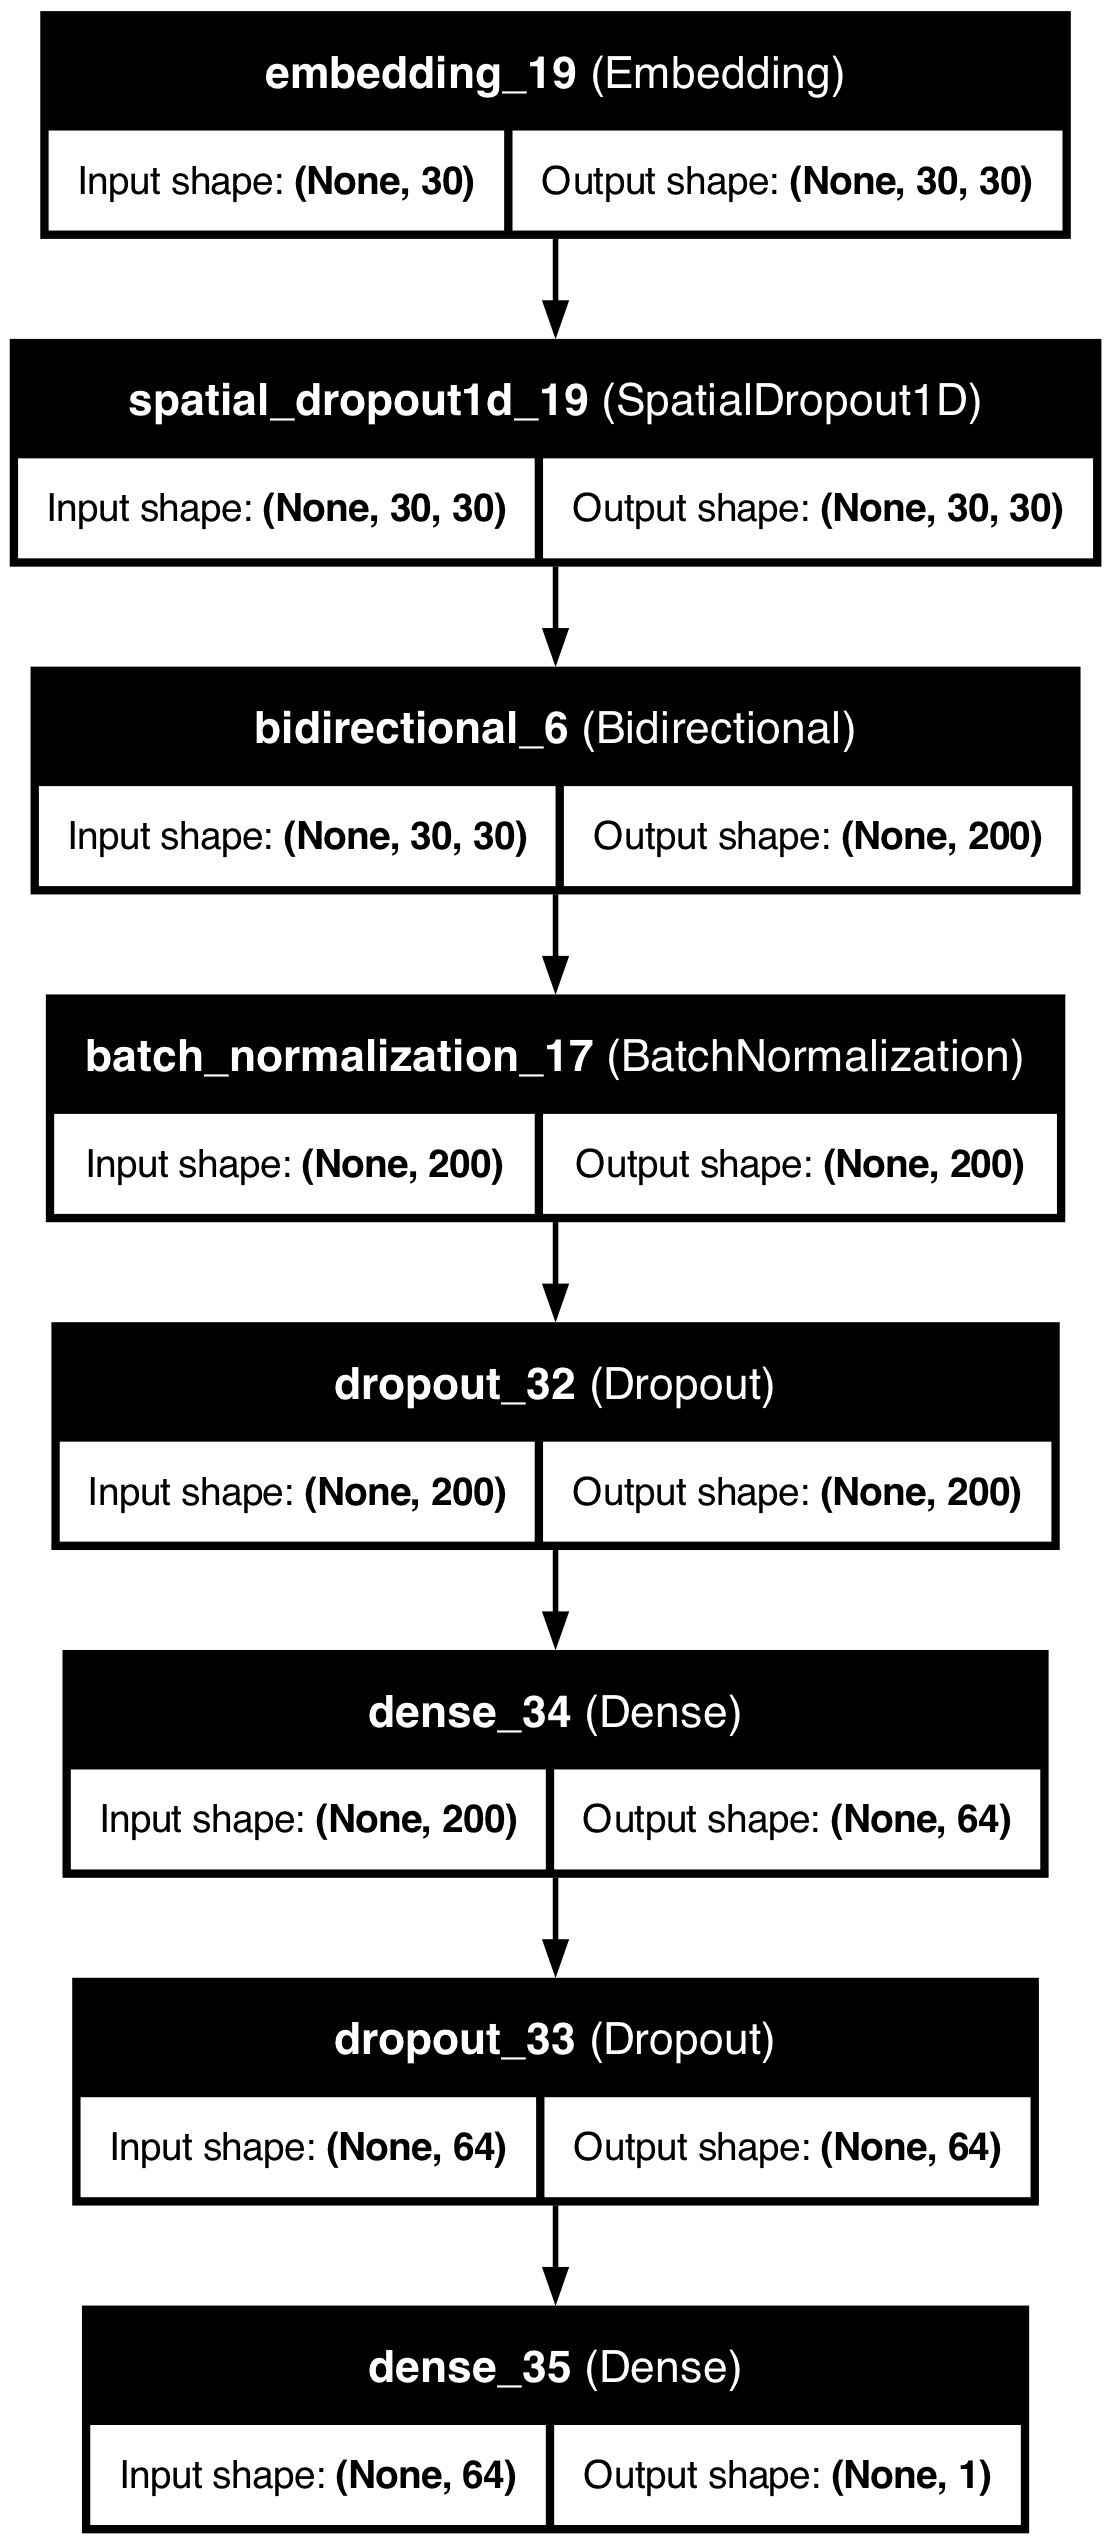

In [249]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [250]:
batch_size = 32
history=model.fit(
    x_train_token, 
    y_train, 
    epochs=20, 
    batch_size=batch_size, 
    validation_data=(x_test_token, y_test),
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose = 2)

Epoch 1/20
535/535 - 15s - 28ms/step - acc: 0.7178 - loss: 0.5920 - val_acc: 0.7731 - val_loss: 0.5455 - learning_rate: 0.0010
Epoch 2/20
535/535 - 14s - 25ms/step - acc: 0.8801 - loss: 0.3128 - val_acc: 0.7903 - val_loss: 0.4939 - learning_rate: 0.0010
Epoch 3/20
535/535 - 14s - 25ms/step - acc: 0.9365 - loss: 0.1762 - val_acc: 0.7890 - val_loss: 0.5555 - learning_rate: 0.0010
Epoch 4/20
535/535 - 14s - 26ms/step - acc: 0.9592 - loss: 0.1203 - val_acc: 0.7855 - val_loss: 0.7204 - learning_rate: 0.0010
Epoch 5/20
535/535 - 14s - 25ms/step - acc: 0.9670 - loss: 0.0969 - val_acc: 0.7806 - val_loss: 0.7618 - learning_rate: 0.0010
Epoch 6/20
535/535 - 14s - 26ms/step - acc: 0.9751 - loss: 0.0727 - val_acc: 0.7812 - val_loss: 0.9683 - learning_rate: 0.0010
Epoch 7/20
535/535 - 14s - 25ms/step - acc: 0.9771 - loss: 0.0688 - val_acc: 0.7735 - val_loss: 0.9716 - learning_rate: 0.0010
Epoch 8/20
535/535 - 14s - 26ms/step - acc: 0.9862 - loss: 0.0451 - val_acc: 0.7812 - val_loss: 1.0178 - learni

In [251]:
test_loss, test_accuracy = model.evaluate(x_test_token, y_test, verbose=0)
print(f"Test accuracy: {test_accuracy:.2f}")
print(f"Test loss: {test_loss:.2f}")

Test accuracy: 0.79
Test loss: 0.49


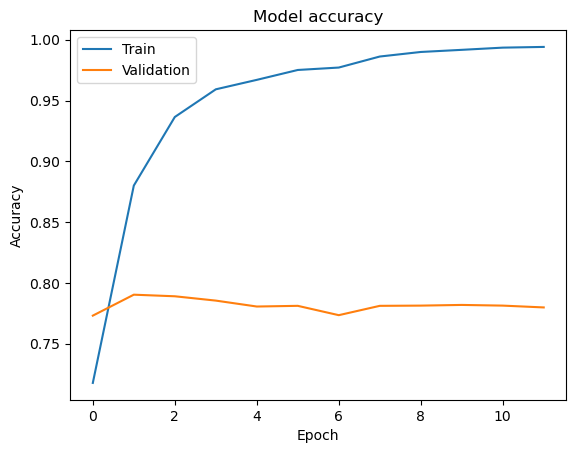

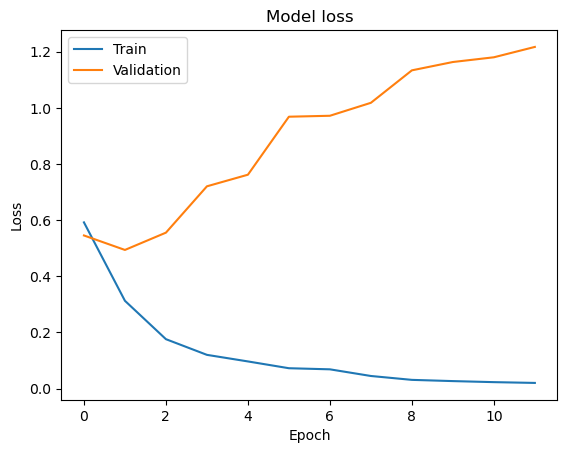

In [252]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

The graphs illustrate the training and validation performance of a model over several epochs.<br>

**Model Loss**
- Training Loss (Blue Line): Decreases steadily, indicating that the model is learning and fitting well to the training data.
- Validation Loss (Orange Line): Increases after a few epochs, suggesting the model is overfitting. It performs well on training data but poorly on unseen validation data.<br>

**Model Accuracy**
- Training Accuracy (Blue Line): Increases rapidly, approaching 100%, showing that the model is learning the training data effectively.
- Validation Accuracy (Orange Line): Remains relatively flat around 75-80%, indicating poor generalization to new data.<br>

**Interpretation**
- The model is likely overfitting. It memorizes the training data but does not generalize well to validation data.

In [253]:
_, train_acc = model.evaluate(x_train_token, y_train, verbose=2)
_, test_acc = model.evaluate(x_test_token, y_test, verbose=2)
print('Train: %.3f, Test: %.4f' % (train_acc, test_acc))

535/535 - 3s - 6ms/step - acc: 0.9662 - loss: 0.1277
167/167 - 1s - 6ms/step - acc: 0.7903 - loss: 0.4939
Train: 0.966, Test: 0.7903


This summary indicates that the model achieved an accuracy of approximately 96.6% on the training data and approximately 79.03% on the test data.

These metrics suggest that while the model performs very well on the training data, its performance drops on unseen test data, which could indicate overfitting—where the model learns patterns specific to the training data but does not generalize well to new data.

In [254]:
y_pred = (model.predict(x_test_token) >= 0.5).astype("int32")
y_pred

167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


array([[0],
       [0],
       [1],
       ...,
       [0],
       [1],
       [1]], dtype=int32)

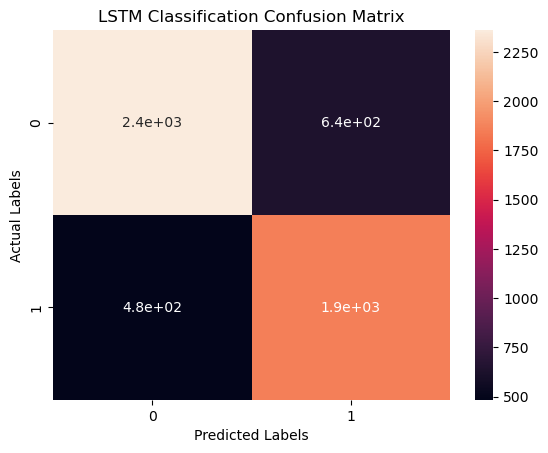

In [260]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

confusion_val = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_val, annot=True)
plt.title('LSTM Classification Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

The image is a confusion matrix for an LSTM (Long Short-Term Memory) classification model. A confusion matrix is a tool used to evaluate the performance of a classification algorithm by comparing predicted labels against actual labels.

Here’s a breakdown of the matrix:
- True Positives (TP): The bottom-right cell (1.9e+03) represents instances where the model correctly predicted the positive class.
- True Negatives (TN): The top-left cell (2.4e+03) shows instances where the model correctly predicted the negative class.
- False Positives (FP): The top-right cell (6.4e+02) indicates instances where the model incorrectly predicted the positive class.
- False Negatives (FN): The bottom-left cell (4.8e+02) represents instances where the model incorrectly predicted the negative class.

In [259]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.79      0.81      2997
           1       0.75      0.79      0.77      2345

    accuracy                           0.79      5342
   macro avg       0.79      0.79      0.79      5342
weighted avg       0.79      0.79      0.79      5342



Overall, the accuracy of the model is reported as 0.79, indicating that approximately 79% of all predictions were correct.